## Step 1: Import Required Libraries

In [6]:
import requests   # Sends HTTP requests to fetch the webpage
from bs4 import BeautifulSoup   # Parses, navigates HTML pages/content and extracts content
import pandas as pd   # Organizes scraped data into a DataFrame for easy viewing/exporting
import time   # Adds delays between requests to avoid hammering the server and to prevent overloading the server
from tqdm import tqdm   # for Progress Visualization
import matplotlib.pyplot as plt   # Data Visualization
import seaborn as sns   # Data Visualization
import re   # To extract specific data patterns and for pattern matching

These libraries are essential for:
- Web scraping (`requests`, `BeautifulSoup`)
- Data handling (`pandas`)
- Time delays (`time`)
- Progress visualization (`tqdm`)
- Data visualization (`matplotlib`, `seaborn`)
- Pattern matching (`re`)


## Step 2: Collect Product Links
Scraping multiple Nykaa category pages by fetching pages to extract individual product page links.

In [10]:
headers = {'User-Agent': 'Mozilla/5.0'}   # Request headers
prod_links = []   # List to collect data

# URL of the nykaa website which is used to scrape data
base_url = 'https://www.nykaa.com/bath-body/body-care/body-lotions-moisturizers/c/371?page_no='

# Scrapes 25 pages
for page_num in range(1, 32):
    print(f"Fetching page {page_num}...")
    url = base_url + str(page_num)
    res = requests.get(url, headers=headers)   # sends the request
    soup = BeautifulSoup(res.content, 'html.parser')

    anchors = soup.find_all('a', attrs={'class': 'css-qlopj4'})
    for a in anchors:
        href = a.get('href')
        if href and href.startswith('/'):
            full_url = 'https://www.nykaa.com' + href
            prod_links.append(full_url)
    
    time.sleep(1)

print(f"Total product links collected: {len(prod_links)}")
print("Done")

Fetching page 1...
Fetching page 2...
Fetching page 3...
Fetching page 4...
Fetching page 5...
Fetching page 6...
Fetching page 7...
Fetching page 8...
Fetching page 9...
Fetching page 10...
Fetching page 11...
Fetching page 12...
Fetching page 13...
Fetching page 14...
Fetching page 15...
Fetching page 16...
Fetching page 17...
Fetching page 18...
Fetching page 19...
Fetching page 20...
Fetching page 21...
Fetching page 22...
Fetching page 23...
Fetching page 24...
Fetching page 25...
Fetching page 26...
Fetching page 27...
Fetching page 28...
Fetching page 29...
Fetching page 30...
Fetching page 31...
Total product links collected: 620
Done


## Step 3: Define Scraping Functions
Using helper functions to fetch product details and extract specific details like product name, volume, and price from each product page.

In [12]:
# function to extract product name
def get_name(soup):
    try:
        return soup.find('h1', attrs={'class': 'css-1gc4x7i'}).text.strip()
    except:
        return 'None'

# function to extract product volume/size
def get_vol(soup):
    try:
        vol_tag = soup.find('span', attrs={'class': 'css-1ctpgu6'})
        if vol_tag:
            vol_text = vol_tag.text.strip()
            parts = vol_text.split('\n')
            if len(parts) >= 3:
                return parts[2].strip()
            else:
                return vol_text
        else:
            return 'None'
    except:
        return 'None'

# function to extract product price
def get_price(soup):
    try:
        return soup.find('span', attrs={'class': 'css-1jczs19'}).text.strip().replace('₹', '').replace(',', '')
    except:
        return 'None'

## Step 4: Scrape Product Data
Loop through each product link and collect all required product details using the functions above.

In [14]:
# Dictionary to store all scraped data
d = {'prod_name': [], 'prod_vol': [], 'prod_price': []}

# Loop through each product link and scrape info
for link in tqdm(prod_links, desc="Scraping Products"):
    try:
        prod_page = requests.get(link, headers=headers)
        prod_soup = BeautifulSoup(prod_page.content, 'html.parser')

        d['prod_name'].append(get_name(prod_soup))
        d['prod_vol'].append(get_vol(prod_soup))
        d['prod_price'].append(get_price(prod_soup))
        
        time.sleep(0.5)   # time delay of 0.5 seconds
    except:
        continue

print("Scraping completed")
print("Done")

Scraping Products: 100%|███████████| 620/620 [09:09<00:00,  1.13it/s]

Scraping completed
Done


## Step 5: Creating a DataFrame
Now we convert the collected dictionary into a pandas DataFrame.

In [18]:
df = pd.DataFrame(d)

# Convert price to numeric
df['prod_price'] = pd.to_numeric(df['prod_price'], errors='coerce')

In [19]:
df.head()   # to see top 5 scraped from dataframe

,prod_name,prod_vol,prod_price
0,Nykaa Wanderlust Dreaming of Paris Fruity Mois...,(300ml),468
1,Vaseline Gluta Hya Antioxidant SPF 50 PA+++ Su...,(175ml),524
2,MCaffeine Summer Breeze Perfume Body Lotion(30...,(300ml),399
3,Sol de Janeiro Beija Flor Collagen-Boosting El...,(240ml),4930
4,Plum BodyLovin' Vanilla Caramello Bestselling ...,(400ml),404


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 620 entries, 0 to 619
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   prod_name   620 non-null    object
 1   prod_vol    620 non-null    object
 2   prod_price  620 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 14.7+ KB


In [21]:
df.describe()

,prod_price
count,620.000000
mean,1027.241935
std,1250.285607
min,90.000000
25%,378.000000
50%,625.000000
75%,1268.000000
max,12400.000000


## Step 6: Clean and Extract Volume Data
Use regular expressions to extract the numerical volume (ml/gm) from the product volume column.

In [23]:
def extract_volume(text):
    try:
        match = re.search(r'(\d+\.?\d*)\s*(ml|g|gm|kg|l)', text.lower())
        if match:
            val = float(match.group(1))
            unit = match.group(2)
            # Normalize to ml
            if unit in ['g', 'gm']:
                return val  # keep grams
            elif unit == 'kg':
                return val * 1000  # convert to grams
            elif unit == 'l':
                return val * 1000  # convert to ml
            else:
                return val  # ml
        else:
            return None
    except:
        return None

df['volume'] = df['prod_vol'].apply(extract_volume)

In [24]:
df['volume']

0      300.0
1      175.0
2      300.0
3      240.0
4      400.0
       ...  
615    236.0
616     60.0
617    236.0
618    150.0
619    250.0
Name: volume, Length: 620, dtype: float64

## Step 7: Extract Brand Name
We take the first word from the product name as the brand.

In [26]:
df['brand'] = df['prod_name'].apply(lambda x: x.split()[0] if x != 'None' else 'Unknown')

In [27]:
df['brand']

0           Nykaa
1        Vaseline
2       MCaffeine
3             Sol
4            Plum
          ...    
615    Victoria's
616           Sol
617    Victoria's
618      Glamveda
619         Lotus
Name: brand, Length: 620, dtype: object

## Step 8: Final Cleanup
Remove rows with missing or invalid price and volume.

In [29]:
df_clean = df.dropna(subset=['prod_price', 'volume'])   # Remove rows where price or volume is missing

df_clean = df_clean[df_clean['volume'] > 0]   # Remove rows where volume is 0 or negative (invalid)

df_clean['volume'] = pd.to_numeric(df_clean['volume'], errors='coerce')   # Convert volume to numeric if it's still object (precaution)

df_clean['price_per_ml'] = df_clean['prod_price'] / df_clean['volume']   # Calculate price per ml/gm

df_clean.reset_index(drop=True, inplace=True)   # Optional: Reset index for clean DataFrame

df_clean.to_csv('nykaa_bodylotions_clean.csv', index=False)   # Export cleaned data to CSV

## Step 9: Data Analysis & Visualizations

### Step 9.1: Univariate Data Visualization
Univariate analysis involves exploring one variable at a time. It helps understand the distribution and general behavior of individual features.

### Price Distribution
This histogram shows how product prices are distributed across all scraped body lotions.

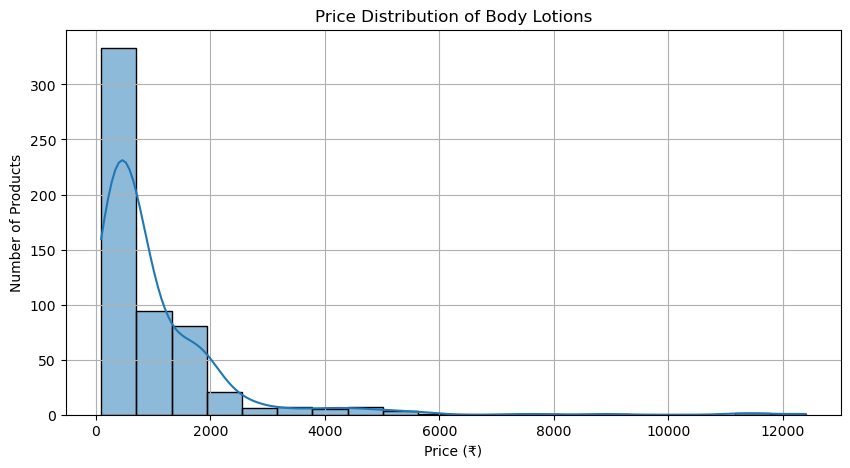

In [32]:
plt.figure(figsize=(10,5))
sns.histplot(df_clean['prod_price'], bins=20, kde=True)
plt.title('Price Distribution of Body Lotions')
plt.xlabel('Price (₹)')
plt.ylabel('Number of Products')
plt.grid(True)
plt.show()

### Volume Distribution
This plot shows the frequency of different product volumes (ml/gm) to understand common sizes.

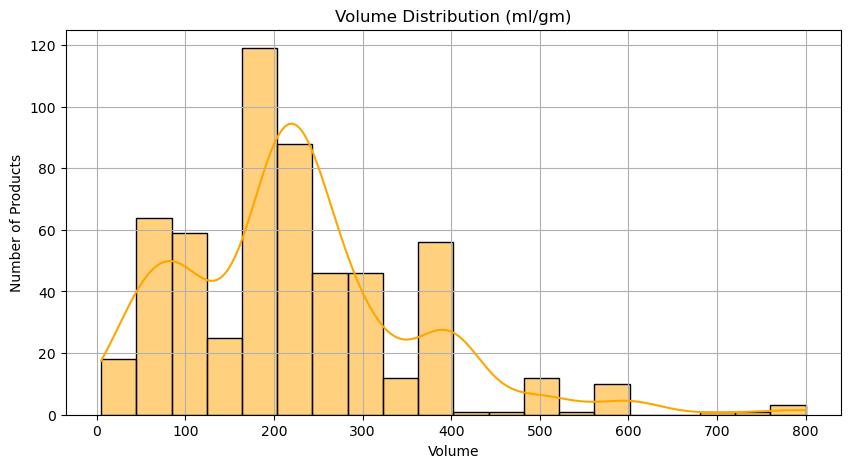

In [34]:
plt.figure(figsize=(10,5))
sns.histplot(df_clean['volume'], bins=20, kde=True, color='orange')
plt.title('Volume Distribution (ml/gm)')
plt.xlabel('Volume')
plt.ylabel('Number of Products')
plt.grid(True)
plt.show()

### Step 9.1.1: Pie Chart - Top Brands by Frequency
This pie chart shows which brands occur most frequently in the scraped product list.

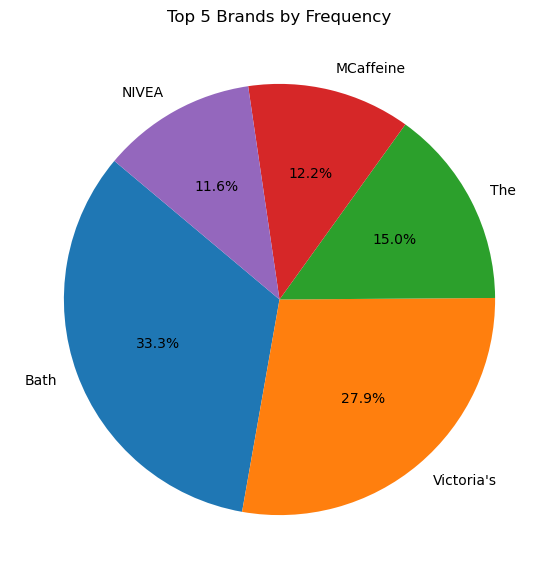

In [36]:
brand_counts = df_clean['brand'].value_counts().head(5)

plt.figure(figsize=(7,7))
plt.pie(brand_counts, labels=brand_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Top 5 Brands by Frequency')
plt.show()

### Discrete Data Visualization (within Univariate)
Here, we analyze **categorical variables** like product brands using bar plots.

#### Brand-wise Average Price
We calculate and visualize the average price of the top 10 most frequent brands.

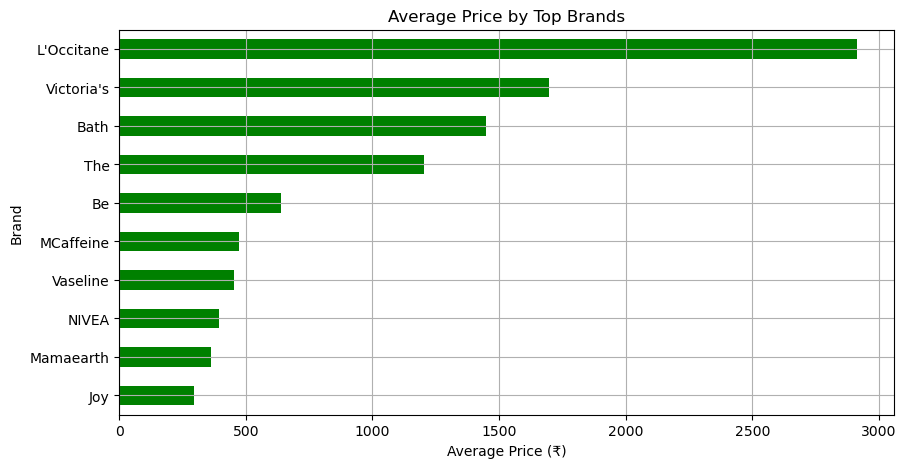

In [38]:
top_brands = df_clean['brand'].value_counts().head(10).index
avg_price_per_brand = df_clean[df_clean['brand'].isin(top_brands)].groupby('brand')['prod_price'].mean().sort_values()

plt.figure(figsize=(10,5))
avg_price_per_brand.plot(kind='barh', color='green')
plt.title('Average Price by Top Brands')
plt.xlabel('Average Price (₹)')
plt.ylabel('Brand')
plt.grid(True)
plt.show()

## Step 9.2: Bivariate Data Visualization
Bivariate analysis examines the relationship between two variables.

### Price vs Volume Scatter Plot
This scatter plot helps us explore the correlation between product volume and its price.

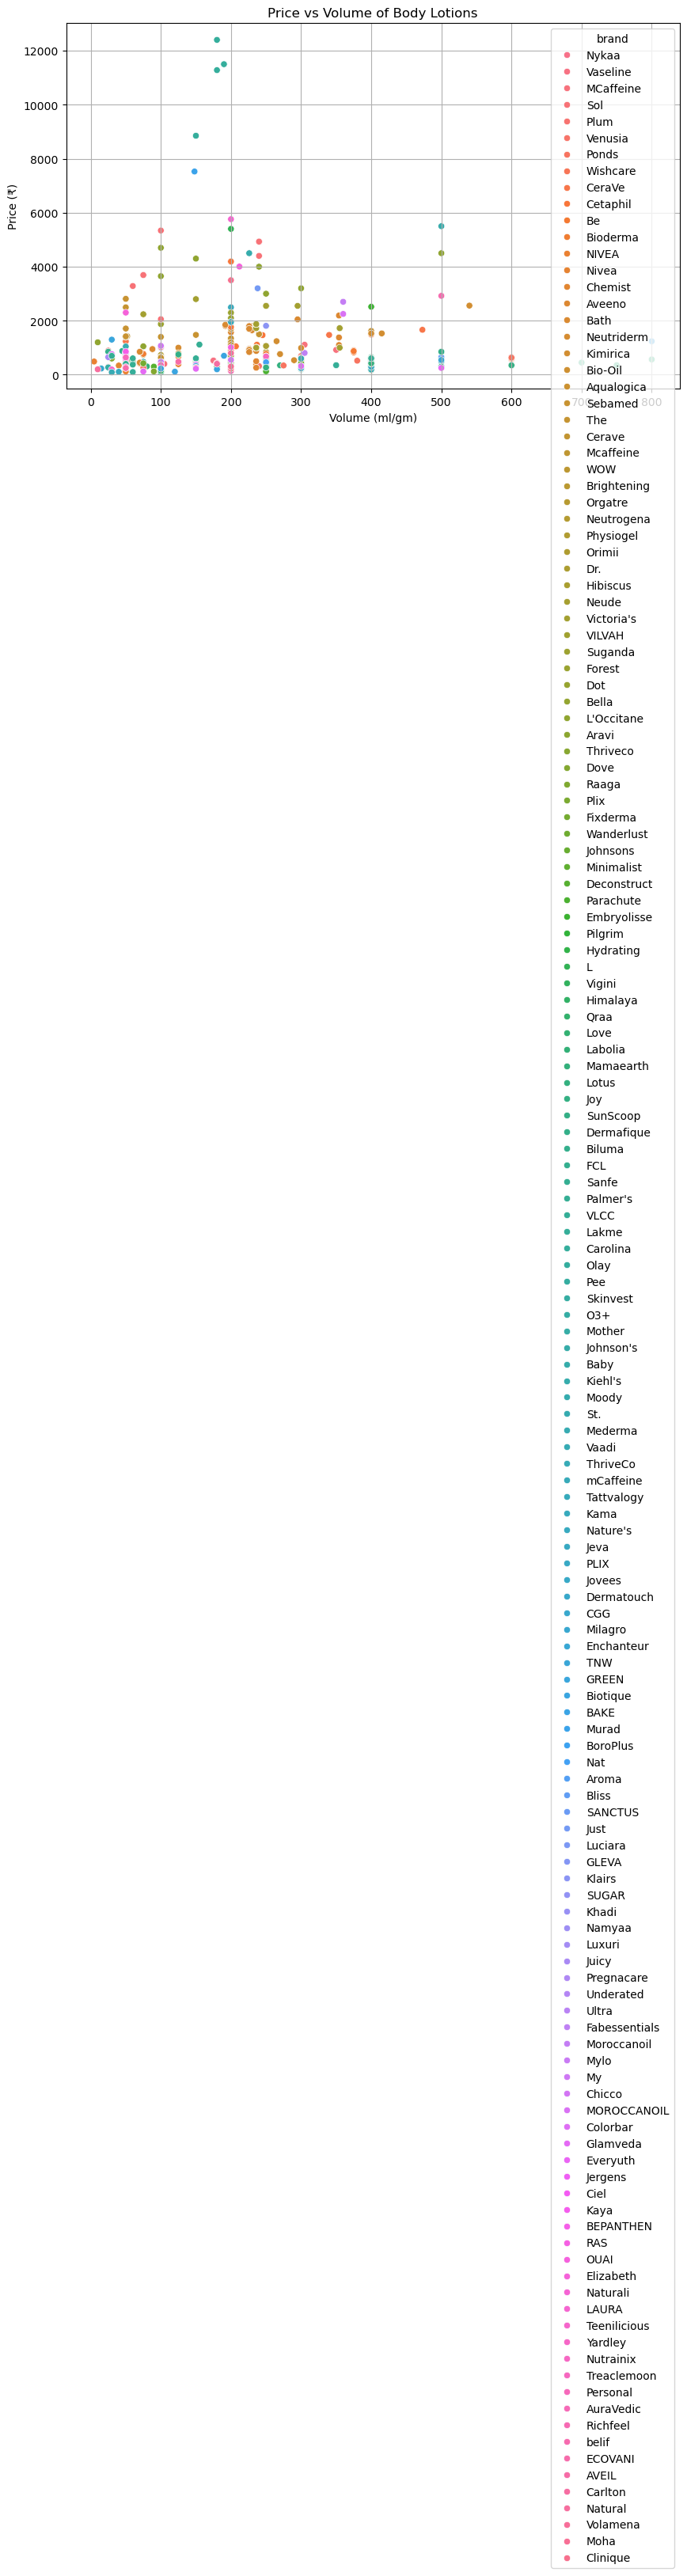

In [40]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='volume', y='prod_price', data=df_clean, hue='brand')
plt.title('Price vs Volume of Body Lotions')
plt.xlabel('Volume (ml/gm)')
plt.ylabel('Price (₹)')
plt.grid(True)
plt.show()

## Step 9.3: Correlation Matrix
We visualize the correlation between numerical features like price, volume, and price per ml using a heatmap. This helps identify potential linear relationships.

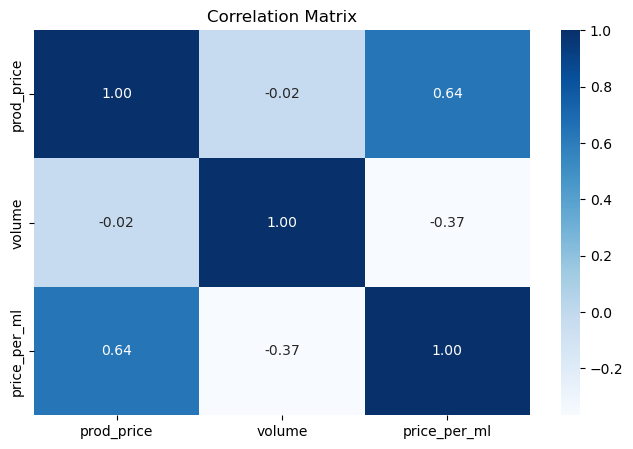

In [42]:
plt.figure(figsize=(8,5))
sns.heatmap(df_clean[['prod_price', 'volume', 'price_per_ml']].corr(), annot=True, cmap='Blues', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

## Step 9.4: Boxplot - Price Distribution by Brand
This boxplot compares price distributions for top brands, allowing us to see variation, medians, and outliers within each brand.

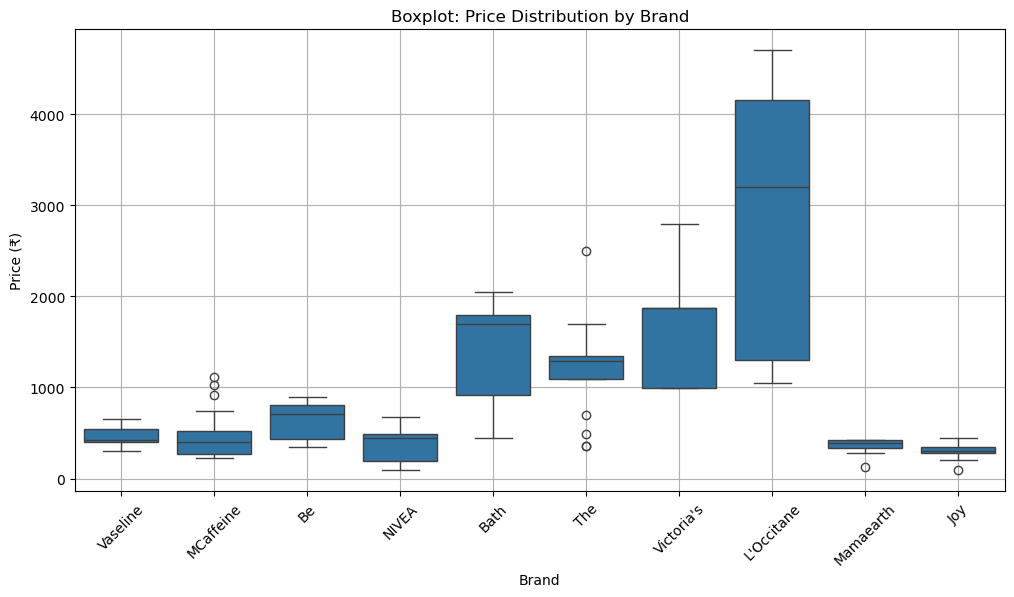

In [44]:
top_brands_df = df_clean[df_clean['brand'].isin(top_brands)]

plt.figure(figsize=(12,6))
sns.boxplot(data=top_brands_df, x='brand', y='prod_price')
plt.title('Boxplot: Price Distribution by Brand')
plt.xlabel('Brand')
plt.ylabel('Price (₹)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

## Most and Least Expensive Products

In [46]:
# Top 10 expensive products
print("Top 10 Most Expensive Products:")
display(df_clean.sort_values(by='prod_price', ascending=False)[['prod_name', 'prod_price']].head(10))

# Top 10 cheapest products
print("\n Top 10 Cheapest Products:")
display(df_clean.sort_values(by='prod_price')[['prod_name', 'prod_price']].head(10))

Top 10 Most Expensive Products:


,prod_name,prod_price
210,Carolina Herrera Good Girl Blush Eau De Parfum...,12400
385,Carolina Herrera Good Girl Eau De Parfum With ...,11500
393,Carolina Herrera Good Girl Eau De Parfum With ...,11280
222,Carolina Herrera Good Girl Eau De Parfum With ...,8850
343,Murad Retinal Resculpt Body Treatment(148ml),7525
483,LAURA MERCIER Neroli du Sud Serum Body Cream(2...,5760
246,Kiehl's Creme De Corps Body Moisturizer With P...,5500
142,L Occitane Almond Milk Concentrate (Milk Conce...,5400
182,Sol de Janeiro Beija Flor Elasti-Body Oil(100ml),5340
110,Sol de Janeiro Beija Flor Collagen-Boosting El...,4930



 Top 10 Cheapest Products:


,prod_name,prod_price
489,"Vaadi Herbals Fairness Cream - Saffron, Aloe V...",90
445,Joy Honey & Almonds Advanced Nourishing Body L...,90
212,Himalaya Aloe And Cucumber Refreshing Body Lot...,92
418,"NIVEA MEN Creme, Non Greasy Moisturizer, Cream...",94
208,Lakme Peach Milk Intense Moisturizer Lotion(60ml),99
407,Nature's Essence Glowing Gold++ Facial Kit(40g),107
124,Parachute Advansed Cocoa Repair Body Lotion Fo...,110
410,Biotique Winter Cherry Rejuvenating Body Lotio...,112
171,NIVEA Soft Light Moisturizer Cream Peppy Pomeg...,119
285,Dove Body Love Nourished Radiance Body Lotion(...,120


## Cost-Effectiveness (Price per ml)

In [48]:
# Most cost-effective products
print("Most Cost-Effective Products (Lowest ₹ per ml):")
display(df_clean.sort_values(by='price_per_ml')[['prod_name', 'prod_price', 'volume', 'price_per_ml']].head(10))

# Most expensive per ml
print("\n Most Expensive Products per ml:")
display(df_clean.sort_values(by='price_per_ml', ascending=False)[['prod_name', 'prod_price', 'volume', 'price_per_ml']].head(10))


Most Cost-Effective Products (Lowest ₹ per ml):


,prod_name,prod_price,volume,price_per_ml
54,Orgatre Aloe Hydration Body Lotion Moisturizer...,164,400.0,0.410000
124,Parachute Advansed Cocoa Repair Body Lotion Fo...,110,250.0,0.440000
186,Joy Honey & Almonds Advanced Nourishing Lightw...,353,750.0,0.470667
362,St. Ives Renewing Collagen & Elastin Body Loti...,190,400.0,0.475000
256,St. Ives Hydrating Vitamin E & Avocado Body Lo...,190,400.0,0.475000
451,Everyuth Naturals Body Lotion - Sun Care Berri...,250,500.0,0.500000
278,Parachute Advansed Soft Touch Body Lotion For ...,128,250.0,0.512000
299,Nature's Essence Nourishing Cleansing Milk Alm...,214,400.0,0.535000
304,Joy Intense Moisture Dryness Repair Body Lotio...,349,600.0,0.581667
524,Joy Honey & Almonds Ultimate Nourishing Body M...,349,600.0,0.581667



 Most Expensive Products per ml:


,prod_name,prod_price,volume,price_per_ml
493,L'Occitane Organic-Certified Pure Shea Butter(...,1200,10.0,120.000000
538,NIVEA On-the-go Body Care Essentials - Mini(4....,488,4.8,101.666667
210,Carolina Herrera Good Girl Blush Eau De Parfum...,12400,180.0,68.888889
393,Carolina Herrera Good Girl Eau De Parfum With ...,11280,180.0,62.666667
385,Carolina Herrera Good Girl Eau De Parfum With ...,11500,190.0,60.526316
222,Carolina Herrera Good Girl Eau De Parfum With ...,8850,150.0,59.000000
165,Sebamed Baby Bath Routine Combo(50ml),2810,50.0,56.200000
559,Sol de Janeiro Glowmotions Body Oil Glow Anywh...,3285,60.0,54.750000
182,Sol de Janeiro Beija Flor Elasti-Body Oil(100ml),5340,100.0,53.400000
343,Murad Retinal Resculpt Body Treatment(148ml),7525,148.0,50.844595


## Step 10: Conclusion
- We successfully scraped product data from Nykaa's body lotion section without relying on customer reviews or JavaScript-rendered content.
- We analyzed key metrics like **price**, **volume**, **brand distribution**, and **cost-effectiveness**.
- The results highlight affordable options, premium brands, and volume trends in the market.

This project demonstrates how basic product data can yield useful insights into an e-commerce platform's product segment.